In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

In [2]:
def get_data():
    train = og_train.copy()
    test = og_test.copy()
    return train, test


# mapping columns datas
def mapping_col(col, col_mapping):
    for dataset in train_test_data:
        dataset[col] = dataset[col].map(col_mapping)

def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts() 
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead'] 
    df.plot(kind='bar',stacked=True , figsize=(10,5))

def feature_drop(drop):
    train = train.drop(drop, axis=1)
    test = test.drop(drop, axis=1) 

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)
    
def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)



In [3]:
og_train = pd.read_csv('/kaggle/input/titanic/train.csv')
og_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train, test = get_data()

In [5]:
train_test_data = [train, test]

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
print('Train data' , train.isnull().sum(), sep='\n')
print('Test data' , test.isnull().sum(), sep='\n')

# Age, Cabin, Embarked => Have null value

Train data
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## 01.SEX

In [8]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [9]:
sex_mapping = {'male' : 0 , 'female' : 1}
mapping_col('Sex', sex_mapping)

In [10]:
train['Sex'].unique()

array([0, 1])

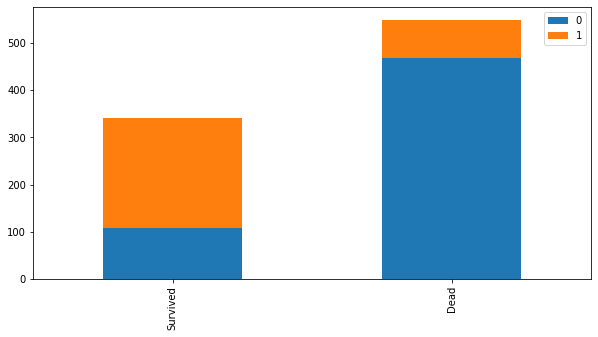

In [11]:
bar_chart('Sex')

## 02. Add Title Col


In [12]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Cabin'] = dataset['Cabin'].str.extract('([A-Za-z]+)', expand=False)

In [13]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2,
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
mapping_col('Title',title_mapping)

In [14]:
train['Title'].value_counts()

0    517
1    182
2    125
3     67
Name: Title, dtype: int64

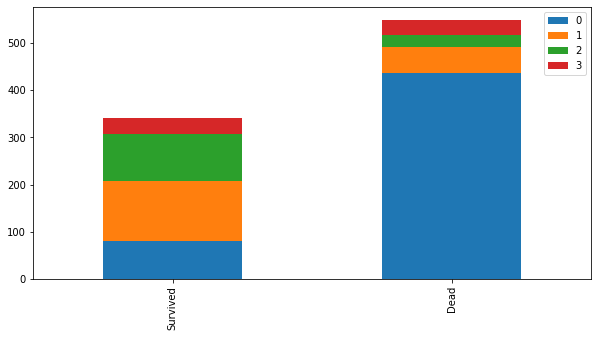

In [15]:
bar_chart('Title')

## 03. Add FamilySize and IsAlone


In [16]:
for dataset in train_test_data:
    # FamilySize = SibSp + Parch + Self
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    # FamilySize == 0 => 1
    dataset['IsAlone'] = 1
    
    # FamilySize > 1 => 0
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0

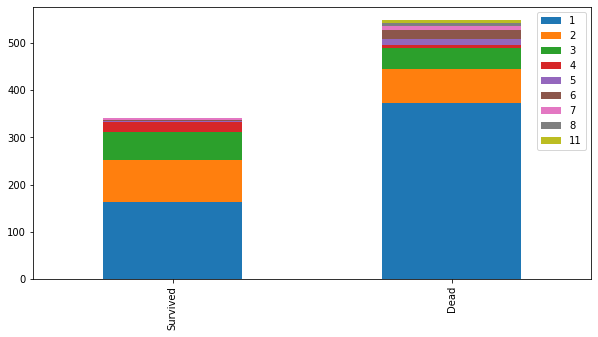

In [17]:
bar_chart('FamilySize')

In [18]:
def familySize_to_cat(size):
    if size == 1: return 0
    if size >= 2 and size <= 4: return 1
    if size >= 5 and size <= 7: return 2
    if size > 7 : return 3

train['FamilySizeCategory'] = train.FamilySize.apply(familySize_to_cat)
test['FamilySizeCategory'] = test.FamilySize.apply(familySize_to_cat)

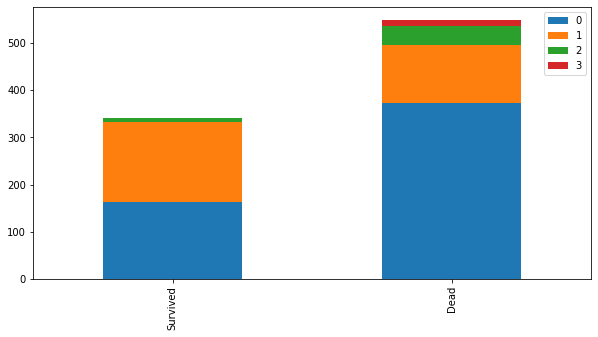

In [19]:
bar_chart('FamilySizeCategory')

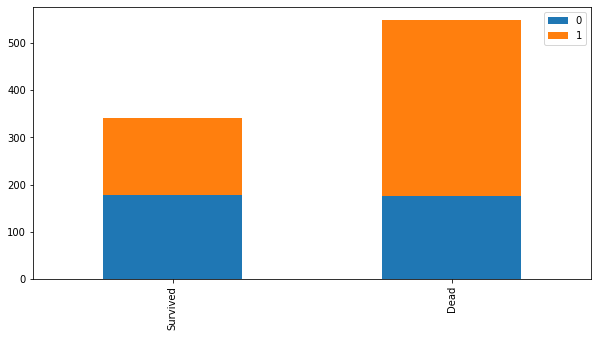

In [20]:
bar_chart('IsAlone')

## 04. Embarked (Have Null Data)
### 04-1. null data processing

In [21]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

### 04-2. mapping Data


In [22]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
mapping_col('Embarked', embarked_mapping)

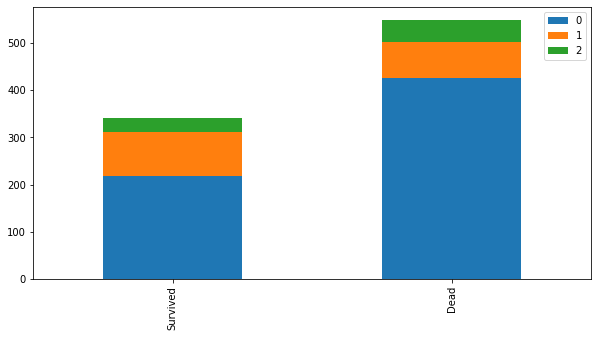

In [23]:
bar_chart('Embarked')

## 05. Age (Have Null Data)
### 05-1. null data processing

In [24]:
for dataset in train_test_data:
    dataset['Age'].fillna(dataset.groupby("Title")["Age"].transform("median"), inplace=True)

### 05-2. cutting and mapping Age


In [25]:
def cut_age(age):
    if age <= 14:
        return 'child'
    if age >= 60:
        return 'senior'
    return 'adult'

test['Age_Cut'] = test.Age.apply(cut_age)
train['Age_Cut'] = train.Age.apply(cut_age)

agecat_mapping = {'child':0, 'senior':1, 'adult':2}
mapping_col('Age_Cut', agecat_mapping)

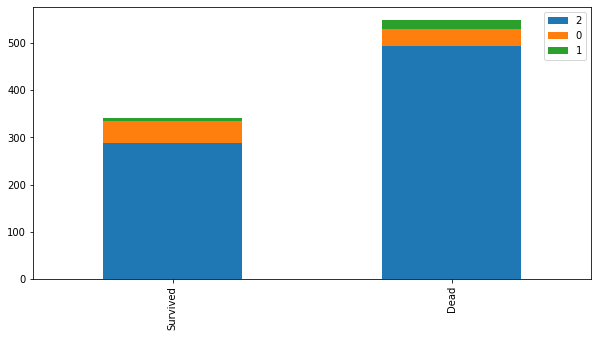

In [26]:
bar_chart('Age_Cut')

In [27]:
med_fare = test.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
test['Fare'] = test['Fare'].fillna(med_fare)

In [28]:
df_all = concat_df(train, test)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [29]:
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

In [30]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [31]:
train, test = divide_df(df_all)

## 06. Fare (Have Null Data only Test)


In [32]:
for dataset in train_test_data:
    dataset["Fare"].fillna(dataset.groupby("Pclass")["Fare"].transform("median"), inplace=True)

In [33]:
train['fare_range'] = pd.qcut(train['Fare'],4)
train.groupby(['fare_range'])['Survived'].mean().to_frame().style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Survived
fare_range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [34]:
train['fare_range'] = 0
test['fare_range'] = 0
for dataset in train_test_data:
    dataset.loc[dataset['Fare'] <= 7.91, 'fare_range'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'fare_range'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'fare_range'] = 2
    dataset.loc[dataset['Fare'] > 31, 'fare_range'] = 3

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


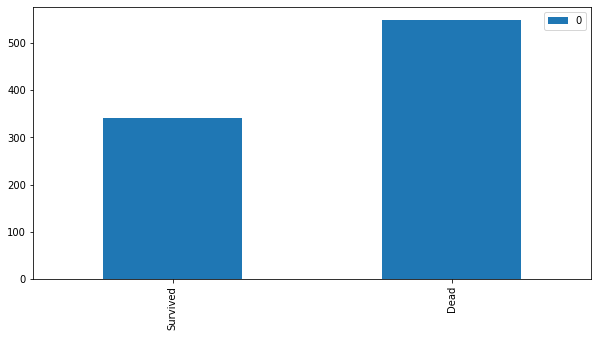

In [35]:
bar_chart('fare_range')

In [36]:
# drop col
feature_drop = ['Name', 'Ticket', 'FamilySize', 'SibSp', 'Parch','Cabin', 'Age']

train = train.drop(feature_drop, axis=1)
test = test.drop(feature_drop, axis=1)

In [37]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
train['Deck'] = LabelEncoder().fit_transform(train['Deck'])
test['Deck'] = LabelEncoder().fit_transform(test['Deck'])

In [38]:
train.head()

,Age_Cut,Embarked,FamilySizeCategory,Fare,IsAlone,PassengerId,Pclass,Sex,Survived,Title,Deck,fare_range
0,2,0,1,7.2500,0,1,3,0,0.0,0,3,0
1,2,1,1,71.2833,0,2,1,1,1.0,2,0,0
2,2,0,0,7.9250,1,3,3,1,1.0,1,3,0
3,2,0,1,53.1000,0,4,1,1,1.0,2,0,0
4,2,0,0,8.0500,1,5,3,0,0.0,0,3,0


In [39]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'FamilySizeCategory']
encoded_features = []
train_test_data = [train, test]

for df in train_test_data:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

train = pd.concat([train, *encoded_features[:6]], axis=1)
test = pd.concat([test, *encoded_features[6:]], axis=1)

In [40]:
corr_matrix = train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived                1.000000
Sex                     0.543351
Sex_2                   0.543351
Title                   0.445792
Title_3                 0.339040
Title_2                 0.327093
Pclass_1                0.285904
FamilySizeCategory_2    0.279855
Fare                    0.257307
Deck_2                  0.213430
Deck_1                  0.202551
Embarked_2              0.168240
Embarked                0.106811
Pclass_2                0.093349
FamilySizeCategory      0.083976
Title_4                 0.081238
Deck_3                  0.058617
Embarked_3              0.003650
PassengerId            -0.005007
FamilySizeCategory_3   -0.089167
FamilySizeCategory_4   -0.096040
Age_Cut                -0.109216
Embarked_1             -0.149683
FamilySizeCategory_1   -0.203367
IsAlone                -0.203367
Deck                   -0.297898
Deck_4                 -0.316912
Pclass_3               -0.322308
Pclass                 -0.338481
Sex_1                  -0.543351
Title_1   

## MinMaxScaler processing


In [41]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

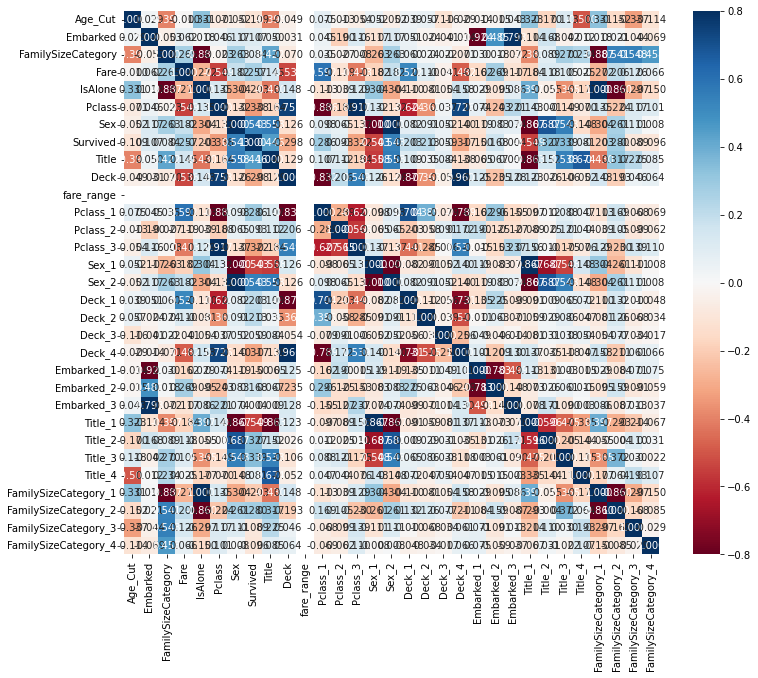

In [42]:
plt.figure(figsize=(12, 10))
sns.heatmap(train.drop('PassengerId', axis=1).corr(), annot=True, fmt='.3f', cmap='RdBu', vmax=0.8, vmin=-0.8)
plt.show()

In [43]:
X = train.drop(['Survived'],axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
y = train['Survived']
X = train.drop(['Survived'],axis=1)
X.head()

,Age_Cut,Embarked,FamilySizeCategory,Fare,IsAlone,PassengerId,Pclass,Sex,Title,Deck,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,FamilySizeCategory_1,FamilySizeCategory_2,FamilySizeCategory_3,FamilySizeCategory_4
0,2,0,1,7.2500,0,1,3,0,0,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,1,71.2833,0,2,1,1,2,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,0,0,7.9250,1,3,3,1,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,0,1,53.1000,0,4,1,1,2,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2,0,0,8.0500,1,5,3,0,0,3,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
list_ = list(X)
list_

['Age_Cut',
 'Embarked',
 'FamilySizeCategory',
 'Fare',
 'IsAlone',
 'PassengerId',
 'Pclass',
 'Sex',
 'Title',
 'Deck',
 'fare_range',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_1',
 'Sex_2',
 'Deck_1',
 'Deck_2',
 'Deck_3',
 'Deck_4',
 'Embarked_1',
 'Embarked_2',
 'Embarked_3',
 'Title_1',
 'Title_2',
 'Title_3',
 'Title_4',
 'FamilySizeCategory_1',
 'FamilySizeCategory_2',
 'FamilySizeCategory_3',
 'FamilySizeCategory_4']

# Modeling

In [46]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [47]:
numerical_cols = [list_.pop(3)]
categorical_cols = list_

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Preprocessing of training data, fit model 
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.825


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import eli5
from eli5.sklearn import PermutationImportance

In [49]:
lr = LogisticRegression(C = 1, penalty= 'l2', solver= 'liblinear', random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test).astype(int)
accuracy_score(y_pred, y_test)

0.7988826815642458

In [50]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(5, 8, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'missing': np.nan,
            'use_label_encoder': False
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)


0.8160051216389246
{'booster': 'gbtree', 'colsample_bytree': 0.885, 'eval_metric': 'auc', 'gamma': 0.835, 'learning_rate': 0.0205, 'max_depth': 5, 'min_child_weight': 3.2, 'missing': nan, 'n_estimators': 877, 'objective': 'binary:logistic', 'subsample': 0.965, 'tree_method': 'exact', 'use_label_encoder': False}
0.8046981187826259
{'booster': 'gbtree', 'colsample_bytree': 0.53, 'eval_metric': 'auc', 'gamma': 1.0, 'learning_rate': 0.0067, 'max_depth': 7, 'min_child_weight': 8.325000000000001, 'missing': nan, 'n_estimators': 547, 'objective': 'binary:logistic', 'subsample': 0.755, 'tree_method': 'exact', 'use_label_encoder': False}
0.8117896188318724
{'booster': 'gbtree', 'colsample_bytree': 0.6950000000000001, 'eval_metric': 'auc', 'gamma': 0.9550000000000001, 'learning_rate': 0.0368, 'max_depth': 6, 'min_child_weight': 3.825, 'missing': nan, 'n_estimators': 856, 'objective': 'binary:logistic', 'subsample': 0.925, 'tree_method': 'exact', 'use_label_encoder': False}
0.8258347286516301
{'b

In [51]:
params = {'booster': 'gbtree',
 'colsample_bytree': 0.8,
 'eval_metric': 'auc',
 'gamma': 0.595,
 'learning_rate': 0.0015,
 'max_depth': 7,
 'min_child_weight': 8.575000000000001,
 'missing': np.nan,
 'n_estimators': 970,
 'objective': 'binary:logistic',
 'subsample': 0.5700000000000001,
 'tree_method': 'exact',
 'use_label_encoder': False}


XGB_Classifier = XGBClassifier(**params)
XGB_Classifier.fit(X_train, y_train)
Y_pred = XGB_Classifier.predict(X_test).astype(int)
XGB_Classifier.score(X_train, y_train)
acc_XGB_Classifier = round(XGB_Classifier.score(X_train, y_train) * 100, 2)
acc_XGB_Classifier

81.32

In [52]:
params = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.635,
 'learning_rate': 0.015300000000000001,
 'max_depth': 6,
 'min_child_weight': 4.675,
 'n_estimators': 249,
 'num_leaves': 116,
 'objective': 'binary'}

LGB_Classifier = LGBMClassifier(**params)
LGB_Classifier.fit(X_train, y_train)
Y_pred = LGB_Classifier.predict(test).astype(int)
LGB_Classifier.score(X_train, y_train)
acc_LGB_Classifier = round(LGB_Classifier.score(X_train, y_train) * 100, 2)
acc_LGB_Classifier

87.5

In [53]:
params = {'max_depth': 6, 'n_estimators': 644}

gradient_boosting = GradientBoostingClassifier(**params)
gradient_boosting.fit(X_train, y_train)
Y_pred = gradient_boosting.predict(test).astype(int)
gradient_boosting.score(X_train, y_train)
acc_gradient_boosting = round(gradient_boosting.score(X_train, y_train) * 100, 2)
acc_gradient_boosting

100.0

# Make Submission (GB, LGB, XGB, LR)

In [54]:
y_pred = gradient_boosting.predict(test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived' : y_pred.astype('int64')
})

submission.to_csv('GBsubmission.csv', index=False) #78229

In [55]:
y_pred = LGB_Classifier.predict(test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived' : y_pred.astype('int64')
})

submission.to_csv('LGBsubmission.csv', index=False) #77751

In [56]:
y_pred = XGB_Classifier.predict(test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived' : y_pred.astype('int64')
})

submission.to_csv('XGBsubmission.csv', index=False) #78947

In [57]:
y_pred = lr.predict(test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived' : y_pred.astype('int64')
})

submission.to_csv('LRsubmission.csv', index=False) #75598

In [58]:
submission

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0


# Best model this notebook : XGB_Classifier (score : 0.78947)